# YASA

This notebook demonstrates how to use YASA to perform **multi-channels sleep spindles detection** from a NumPy array (example 1) or a MNE Raw object (example 2).

Please make sure to install YASA first by typing the following line in your terminal or command prompt:

`pip install --upgrade yasa`

**Important**
- The data must be a numpy array of shape *(n_channels, n_samples)*.
- The sampling frequency `sf` must be the same for all channels.
- A list of the channel names (`ch_names`) must be provided as well.
- The unit of the data must be $\mu V$. Note that the default unit in [MNE](https://martinos.org/mne/dev/generated/mne.io.Raw.html) is $V$. Therefore, if you use MNE, you must multiply your data by 1e6 (1 $V$ = 1,000,000 $\mu V$).

## Example 1: Using NumPy

To illustrate the multi-channel spindles detection, we load a full-night 3-channels dataset (Cz, Fz, Pz) sampled at 100 Hz. The data is in compressed NumPy format (*.npz*).

In [1]:
import yasa
import numpy as np

# Load data
f = np.load('data_full_6hrs_100Hz_Cz+Fz+Pz.npz')
data, chan = f['data'], f['chan']
sf = 100.
times = np.arange(data.size) / sf

print(data.shape, chan)
print(np.round(data[:, 0:5], 3))

(3, 2161058) ['Cz' 'Fz' 'Pz']
[[15.797 22.307 39.922 25.657 27.094]
 [16.896 26.385 40.966 21.833 24.456]
 [ 5.899 14.297 36.592 26.094 23.395]]


*************

**Applying the detection**

To apply the multi-channel detection, we use the [spindles_detect_multi](https://raphaelvallat.com/yasa/build/html/generated/yasa.spindles_detect_multi.html#yasa.spindles_detect_multi) function

In [2]:
sp = yasa.spindles_detect_multi(data, sf, ch_names=chan, multi_only=False)
print(sp.shape[0], 'spindles detected.')
sp.head().round(3)

1919 spindles detected.


,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,522.54,522.78,523.79,1.25,45.509,10.850,2.131,0.470,13.083,16.0,0.190,Cz,0
1,585.51,586.09,586.38,0.87,59.435,13.185,2.255,0.473,12.946,11.0,0.659,Cz,0
2,598.06,598.62,599.54,1.48,79.922,15.977,2.373,0.421,12.889,19.0,0.376,Cz,0
3,604.36,604.73,605.12,0.76,60.649,12.520,2.209,0.350,12.646,9.0,0.481,Cz,0
4,607.53,607.98,608.05,0.52,50.211,13.847,2.358,0.258,13.452,6.0,0.849,Cz,0


In [3]:
# We print the number of spindles detected per channel, as well as the mean spindles properties per channel.
display(sp['Channel'].value_counts())
display(sp.groupby('Channel').mean().round(2))

Pz    696
Cz    671
Fz    552
Name: Channel, dtype: int64

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,IdxChannel
Channel,,,,,,,,,,,,
Cz,12464.73,12465.27,12465.76,1.04,78.64,17.15,2.43,0.40,12.66,12.84,0.52,0
Fz,12683.03,12683.55,12684.02,0.99,70.92,15.49,2.33,0.38,12.49,12.02,0.52,1
Pz,12479.28,12479.82,12480.31,1.04,71.01,15.40,2.33,0.40,12.66,12.82,0.51,2


In [4]:
# For plotting purposes, we can easily extract a boolean vector that has the same size as the data
bool_vector = yasa.get_bool_vector(data, sf, sp)
print(bool_vector.sum(1))
print(bool_vector)

[70525 55061 73019]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Find spindles that are present on at least two channels

Using the `multi_only=True` argument, we force the detection to keep only the spindles that are present on at least two different channels. Spindles are considered the same if their start or end times fall within the same second. In other words, start and end times are rounded to the nearest integer and compared across channels.

In [5]:
sp_multi = yasa.spindles_detect_multi(data, sf, ch_names=chan, multi_only=True, remove_outliers=True)
print(sp_multi.shape[0], 'spindles detected that are common to at least two electrodes.')
sp_multi.head().round(3)

1244 spindles detected that are common to at least two electrodes.


,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,585.51,586.09,586.38,0.87,59.435,13.185,2.255,0.473,12.946,11.0,0.659,Cz,0
1,598.06,598.62,599.54,1.48,79.922,15.977,2.373,0.421,12.889,19.0,0.376,Cz,0
2,604.36,604.73,605.12,0.76,60.649,12.520,2.209,0.350,12.646,9.0,0.481,Cz,0
3,655.06,655.50,655.88,0.82,47.596,10.832,2.149,0.369,13.297,11.0,0.530,Cz,0
4,725.60,726.50,726.88,1.28,77.591,18.836,2.370,0.288,12.370,15.0,0.698,Cz,0


In [6]:
display(sp_multi['Channel'].value_counts())
display(sp_multi.groupby('Channel').mean().round(2))

Cz    478
Pz    414
Fz    352
Name: Channel, dtype: int64

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,IdxChannel
Channel,,,,,,,,,,,,
Cz,12727.83,12728.38,12728.86,1.03,76.53,16.70,2.42,0.41,12.62,12.66,0.52,0
Fz,13095.51,13096.01,13096.46,0.95,68.70,15.05,2.33,0.38,12.47,11.57,0.52,1
Pz,12638.59,12639.14,12639.65,1.06,70.24,15.23,2.33,0.41,12.64,13.08,0.51,2


### Find spindles that are present on ALL channels only

The code below show how to apply an even more stringent selection: only the spindles that are common across all electrodes are kept. This method is not natively implemented in YASA.

In [7]:
from functools import reduce
grp_start = sp.groupby('Channel')['Start'].apply(lambda x: list(np.round(x).astype(int))).to_dict()
grp_end = sp.groupby('Channel')['End'].apply(lambda x: list(np.round(x).astype(int))).to_dict()

intersect_start = reduce(np.intersect1d, (grp_start[c] for c in sp['Channel'].unique()))
intersect_end = reduce(np.intersect1d, (grp_end[c] for c in sp['Channel'].unique()))

idx_start = np.in1d(sp['Start'].round().astype(int), intersect_start)
idx_end = np.in1d(sp['End'].round().astype(int), intersect_end)
idx_good = np.logical_or(idx_start, idx_end)

# Now we keep only these spindles in the dataframe
print(sp[idx_good].shape[0], 'unique spindles that are common across ALL channels.')
sp[idx_good].head().round(3)

1030 unique spindles that are common across ALL channels.


,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
3,604.36,604.73,605.12,0.76,60.649,12.520,2.209,0.350,12.646,9.0,0.481,Cz,0
6,631.57,631.81,632.18,0.61,158.228,37.444,3.150,0.436,12.612,7.0,0.387,Cz,0
9,735.12,735.90,736.39,1.27,80.165,16.962,2.543,0.579,12.675,15.0,0.609,Cz,0
10,744.01,744.98,745.47,1.46,79.723,16.769,2.602,0.636,12.773,19.0,0.660,Cz,0
13,1321.01,1321.76,1322.28,1.27,98.536,21.469,2.545,0.299,12.359,16.0,0.586,Cz,0


### Test with a bad channel

Here, we create a fake channel with no spindle to test the detection.

In [8]:
# data[1, :] = np.random.rand(data.shape[1])
data[1, :] = np.sin(0.1 * np.arange(data.shape[1]))
sp_bad = yasa.spindles_detect_multi(data, sf, ch_names=chan, multi_only=False)
display(sp_bad['Channel'].value_counts())
sp.head().round(3)

17-Mar-20 16:38:40 | WARNING | No spindles were found in data. Returning None.
17-Mar-20 16:38:40 | WARNING | No spindles were found in channel Fz.


Pz    696
Cz    671
Name: Channel, dtype: int64

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,522.54,522.78,523.79,1.25,45.509,10.850,2.131,0.470,13.083,16.0,0.190,Cz,0
1,585.51,586.09,586.38,0.87,59.435,13.185,2.255,0.473,12.946,11.0,0.659,Cz,0
2,598.06,598.62,599.54,1.48,79.922,15.977,2.373,0.421,12.889,19.0,0.376,Cz,0
3,604.36,604.73,605.12,0.76,60.649,12.520,2.209,0.350,12.646,9.0,0.481,Cz,0
4,607.53,607.98,608.05,0.52,50.211,13.847,2.358,0.258,13.452,6.0,0.849,Cz,0


In [9]:
bool_vector = yasa.get_bool_vector(data, sf, sp_bad)
bool_vector.sum(1)

array([70525,     0, 73019])

**************

## Example 2: Using a Raw object from MNE-Python

This example demonstrates how to manipulate [MNE Raw object](https://mne-tools.github.io/stable/generated/mne.io.Raw.html#mne.io.Raw). The MNE package has several [functions](https://mne-tools.github.io/stable/python_reference.html#module-mne.io) to load the most standard EEG file formats (EDF, BrainVision, EEGLab, FieldTrip...).

### Load using MNE
For the sake of this example, we'll load a PSG file encoded in the native MNE format (*.fif) using the `mne.io.read_raw_fif` function.

In [10]:
import mne

# Load the raw object
raw = mne.io.read_raw_fif('sub-02_mne_raw.fif', preload=True)

Opening raw data file sub-02_mne_raw.fif...
    Range : 0 ... 293999 =      0.000 ...  2939.990 secs
Ready.
Reading 0 ... 293999  =      0.000 ...  2939.990 secs...


In [11]:
# Let's have a look at the data
print('Chan =', raw.ch_names)
print('Sampling frequency =', raw.info['sfreq'])
print('Data shape =', raw._data.shape)

Chan = ['F3', 'F4', 'C3', 'C4', 'O1', 'O2', 'EOG1', 'EOG2', 'EMG1']
Sampling frequency = 100.0
Data shape = (9, 294000)


### Applying YASA

In [12]:
# Keep only the channels of interests
raw.pick_types(eeg=True).drop_channels(['O1', 'O2'])
print('Chan =', raw.ch_names)

Chan = ['F3', 'F4', 'C3', 'C4']


In [13]:
# Multi-channel spindles detection
# Note that since we're using a MNE Raw object, there is no need
# to manually specify the sampling frequency and channel names.
sp = yasa.spindles_detect_multi(raw)
sp.head().round(3)

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,879.76,880.04,880.53,0.77,49.915,9.490,2.017,0.393,13.803,10.0,0.359,F3,0
1,1068.45,1069.16,1069.46,1.01,39.570,7.860,1.521,0.268,13.472,13.0,0.696,F3,0
2,1078.82,1079.21,1079.38,0.56,41.574,9.711,2.070,0.409,13.175,8.0,0.684,F3,0
3,1099.28,1099.61,1100.42,1.14,46.057,9.761,2.057,0.592,13.291,15.0,0.287,F3,0
4,1104.88,1104.98,1105.77,0.89,31.216,7.461,1.564,0.248,13.441,10.0,0.111,F3,0


In [14]:
bool_vector = yasa.get_bool_vector(raw, detection=sp)
print(bool_vector.sum(1))
print(bool_vector)

[3809 4124 4237 4365]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


**Plot an average template of the detected spindles per channel**

In [15]:
# Extract data of each event centered on the spindles peak
df_sync = yasa.get_sync_events(raw, detection=sp, center='Peak', time_before=1, time_after=1)
df_sync

,Time,Event,Amplitude,Channel,IdxChannel
0,-1.00,0,-10.407142,C3,2
1,-0.99,0,-9.373844,C3,2
2,-0.98,0,-6.388535,C3,2
3,-0.97,0,0.391988,C3,2
4,-0.96,0,3.730927,C3,2
...,...,...,...,...,...
38788,0.96,50,-8.721683,F4,1
38789,0.97,50,-1.998528,F4,1
38790,0.98,50,2.629032,F4,1
38791,0.99,50,2.958312,F4,1


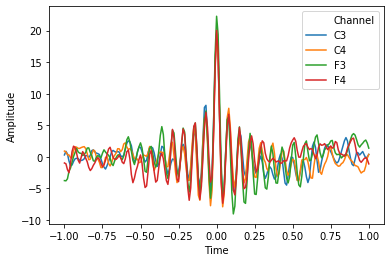

In [16]:
import seaborn as sns
sns.lineplot(x='Time', y='Amplitude', hue='Channel', data=df_sync, ci=None)

**Same but after filtering the signal in the sigma band**

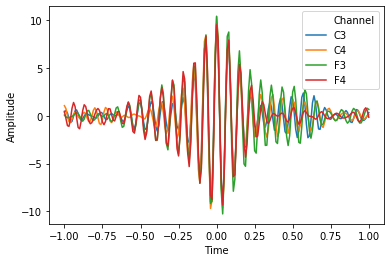

In [17]:
# Extract data of each event centered on the spindles peak
df_sync_filt = yasa.get_sync_events(raw.copy().filter(12, 16, verbose=0),
                                    detection=sp, center='Peak', 
                                    time_before=1, time_after=1)

sns.lineplot(x='Time', y='Amplitude', hue='Channel', data=df_sync_filt, ci=None)